<a href="https://colab.research.google.com/github/LucasPBar/Transfer_Learning_Dogs_x_Cats/blob/main/tl_cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
%matplotlib inline

import os

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

In [29]:
# Importando dados diretamente do site da microsoft
# Link: https://www.microsoft.com/en-us/download/details.aspx?id=54765
!wget --no-check-certificate https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip
!unzip kagglecatsanddogs_5340.zip
!rm kagglecatsanddogs_5340.zip

--2026-01-30 02:50:37--  https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.222.202.7, 2600:1408:ec00:89b::317f, 2600:1408:ec00:887::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.222.202.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   120MB/s    in 11s     

2026-01-30 02:50:48 (74.8 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]

Archive:  kagglecatsanddogs_5340.zip
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [30]:
# Nome da pasta raiz
root = "PetImages"
# Divisão de pesos para dados de treino, validação e teste
train_split, val_split = 0.7, 0.15
# Extraindo os nomes das categorias presentes na pasta raiz
categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['PetImages/Cat', 'PetImages/Dog']


In [31]:
# Ajuda a suprimir avisos de carregamento de imagens corrompidas
import warnings

# Carrega a imagem e faz o pré-processamento para o modelo
def get_image(path):
    try:
        img = image.load_img(path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return img, x
    except Exception as e:
        warnings.warn(f"Could not load image {path}: {e}")
        return None, None

In [32]:
"""
# Carrega as imagens presentes na pasta "root" com um limite de 500 imagens por categoria
"""

"""
Observação: Limitei o carregamento de 500 imagens para cada categoria devido à limitações
do meu computador, como também para acelerar o processo de treinamento.
"""

data = []
num_images_to_load = 500 # Define o número máximo de imagens por categoria

for c, category in enumerate(categories):
    images_in_category = [
        os.path.join(dp, f)
        for dp, dn, filenames in os.walk(category)
        for f in filenames
        if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']
    ]

    # Limita o número de imagens a serem processadas para esta categoria
    processed_count = 0
    for img_path in images_in_category:
        if processed_count >= num_images_to_load:
            break # Para de processar imagens quando o limite é atingido

        img, x = get_image(img_path)
        if img is None or x is None:
            continue # Pula imagens que não puderam ser carregadas

        # Adiciona a imagem processada e sua classe à lista de dados
        data.append({'x':np.array(x[0]), 'y':c})
        processed_count += 1

# count the number of classes
num_classes = len(categories)

In [33]:
"""
Aqui as imagens são embaralhadas para garantir que a ordem não influencie o treinamento do modelo.
"""
random.shuffle(data)

In [34]:
# Divide os dados em conjuntos de treino, validação e teste
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [35]:
# Separando valores das variáveis de entrada e saída
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]


In [36]:
"""
Nesta etapa, os dados de entrada são normalizados para que os valores dos pixels fiquem entre 0 e 1.
Além disso, as variáveis de saída são convertidas para o formato one-hot encoding.
Realizamos essas transformações para melhorar o desempenho do modelo durante o treinamento e
diminuir o risco de viés dentro do modelo.
"""

# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(150, 2)


In [37]:
# Sumário
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 1000 images from 2 categories
train / validation / test split: 700, 150, 150
training data shape:  (700, 224, 224, 3)
training labels shape:  (700, 2)


#### Realizando o treinamento do modelo

In [38]:
# Construção do modelo CNN do zero
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# compilando o modelo para usar a função de perda de entropia cruzada categórica e o otimizador adadelta
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 54s 8s/step - accuracy: 0.4873 - loss: 0.7044 - val_accuracy: 0.5133 - val_loss: 0.6916
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 9s/step - accuracy: 0.5432 - loss: 0.6804 - val_accuracy: 0.5933 - val_loss: 0.6784
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 49s 8s/step - accuracy: 0.6342 - loss: 0.6504 - val_accuracy: 0.5933 - val_loss: 0.6701
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step - accuracy: 0.6243 - loss: 0.6401 - val_accuracy: 0.5800 - val_loss: 0.6744
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 9s/step - accuracy: 0.6496 - loss: 0.6370 - val_accuracy: 0.5867 - val_loss: 0.6567
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 57s 8s/step - accuracy: 0.7007 - loss: 0.5886 - val_accuracy: 0.6067 - val_loss: 0.6657
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 77s 8s/step - accuracy: 0.6701 - loss: 0.5832 - val_accuracy: 0.6533 - val_loss: 0.6352
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - accuracy: 0.7179 - loss: 0.5644 - val_accuracy: 0.6133 - val_loss: 0.6440
Epoch 9/

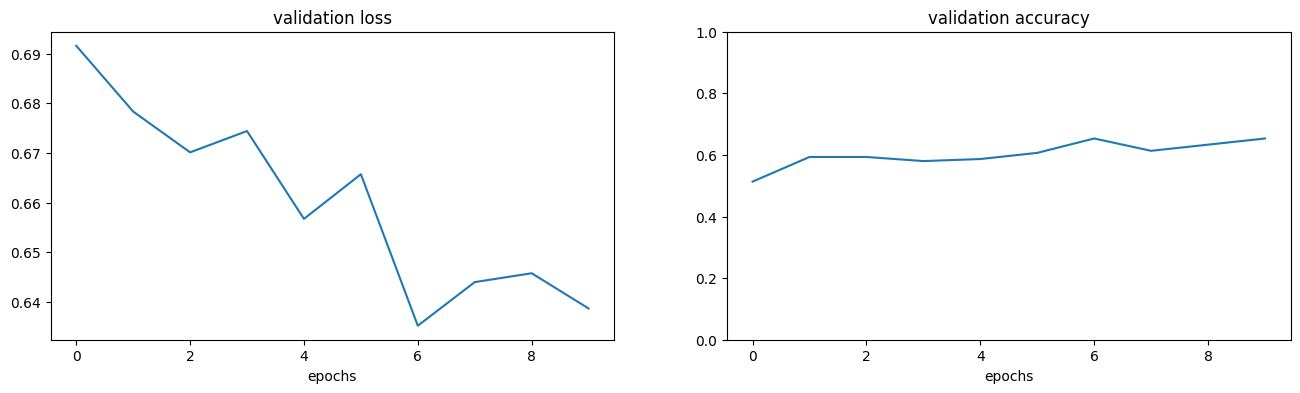

In [40]:
# Avaliação de métricas

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [51]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6612952351570129
Test accuracy: 0.6333333253860474


#### Aplicando o Transfer Learning (Aprendizagem por Transferência)
-> Realizando o treinamento do modelo a partir de um modelo já treinado importado através da biblioteca keras

In [41]:
# Carregando o modelo VGG16 pré-treinado
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# faz uma referência à camada de entrada do VGG
inp = vgg.input

# cria uma nova camada softmax com 'num_classes' neurônios
new_classification_layer = Dense(num_classes, activation='softmax')

# conecta nossa nova camada à penúltima camada do VGG, e faz uma referência a ela
out = new_classification_layer(vgg.layers[-2].output)

# cria uma nova rede entre 'inp' e 'out'
model_new = Model(inp, out)

In [43]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [44]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 522s 90s/step - accuracy: 0.4951 - loss: 1.0473 - val_accuracy: 0.5067 - val_loss: 0.7278
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 462s 78s/step - accuracy: 0.5826 - loss: 0.6596 - val_accuracy: 0.8000 - val_loss: 0.5154
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 462s 78s/step - accuracy: 0.7510 - loss: 0.5433 - val_accuracy: 0.8533 - val_loss: 0.4566
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 497s 78s/step - accuracy: 0.8267 - loss: 0.4683 - val_accuracy: 0.8667 - val_loss: 0.4043
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 513s 80s/step - accuracy: 0.8259 - loss: 0.4298 - val_accuracy: 0.8467 - val_loss: 0.3799
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 559s 91s/step - accuracy: 0.8439 - loss: 0.4088 - val_accuracy: 0.8800 - val_loss: 0.3610
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 532s 92s/step - accuracy: 0.8496 - loss: 0.3833 - val_accuracy: 0.9000 - val_loss: 0.3319
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 549s 94s/step - accuracy: 0.8727 - loss: 0.3495 - val_accuracy: 0.8600 - val_loss:

In [45]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.32619935274124146
Test accuracy: 0.8866666555404663


#### Realizando predições

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_470
Received: inputs=('Tensor(shape=(1, 224, 224, 3))',)
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


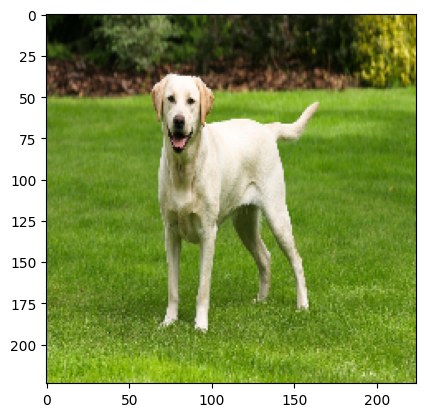

In [46]:
img, x = get_image('dog_test.jpg')
plt.imshow(img)
probabilities = model_new.predict([x])

In [47]:
dog_probability = probabilities[0][1]
print(f"Probabilidade da imagem ser um cachorro: {dog_probability:.4f}")

Probabilidade da imagem ser um cachorro: 1.0000


In [49]:
# Visualização da resposta do modelo
if probabilities[0][1] > 0.5:
    print("É um cachorro!")
else:
    print("Não é um cachorro!")

É um cachorro!


### Comparativo de desempenho entre modelos

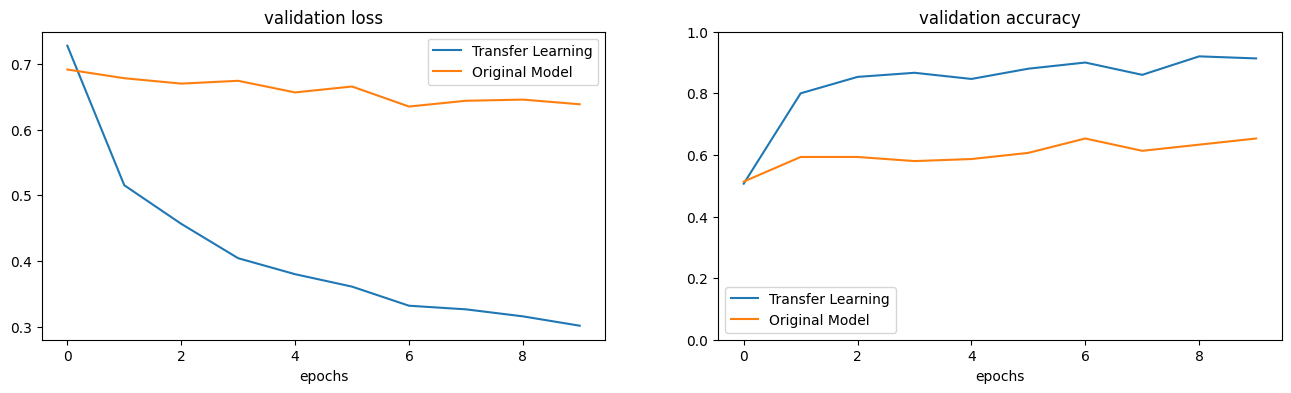

In [53]:
# Avaliação de métricas

"""
O objetivo deste gráfico é comparar o desempenho do modelo original treinado do zero com o modelo
utilizando transferência de aprendizado. Isso nos permite visualizar as diferenças na perda de validação
e na precisão de validação entre os dois modelos ao longo das épocas de treinamento.
"""

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["val_loss"], label='Transfer Learning')
ax.plot(history.history["val_loss"], label='Original Model')
ax.set_title("validation loss")
ax.set_xlabel("epochs")
ax.legend()

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["val_accuracy"], label='Transfer Learning')
ax2.plot(history.history["val_accuracy"], label='Original Model')
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)
ax2.legend()

### Insights do Comparativo de Desempenho:

- **Análise do Gráfico: Desempenho:** O modelo que usou Transfer Learning superou significativamente o modelo original treinado do zero em termos de precisão e redução de erros durante a validação.

- **Análise do Gráfico: Tendências:** O modelo com Transfer Learning aprendeu de forma mais rápida e estável, alcançando resultados melhores em menos tempo de treinamento. O modelo original demonstrou dificuldades para aprender de maneira eficaz.

- **Conclusão do Projeto: Eficácia do Transfer Learning:** A estratégia de Transfer Learning provou ser altamente eficaz, adaptando o conhecimento prévio de um modelo para uma nova tarefa com excelente aproveitamento.

- **Conclusão do Projeto: Vantagem de Modelos Pré-treinados:** Utilizar modelos já treinados em grandes volumes de dados (como o VGG16) é uma grande vantagem, especialmente quando se tem dados limitados, acelerando o processo e melhorando a qualidade dos resultados.